In [44]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score
from  matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
data_pd = pd.read_csv('D:\DS_2nd_year\semester_2nd\[DS108]\Doan\dataset_ds108\isic_dermnet.csv')
data_pd.head()

,image_id,age_approx,anatom_site_general,dx,sex,lesion_id
0,ISIC_4695565,75.0,posterior torso,akiec,female,IL_2485486
1,ISIC_4407081,65.0,head/neck,akiec,female,IL_5173845
2,ISIC_6803155,70.0,head/neck,akiec,male,IL_8876724
3,ISIC_6037786,55.0,head/neck,akiec,female,IL_1728878
4,ISIC_4263601,75.0,head/neck,akiec,male,IL_6263448


In [3]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,age_approx,anatom_site_general,dx,sex
lesion_id,,,,,
DERMNETakiec_0,1,0,0,1,0
DERMNETakiec_1,1,0,0,1,0
DERMNETakiec_10,1,0,0,1,0
DERMNETakiec_11,1,0,0,1,0
DERMNETakiec_12,1,0,0,1,0


In [4]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [5]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'

In [6]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,image_id,age_approx,anatom_site_general,dx,sex,lesion_id,is_duplicate
0,ISIC_4695565,75.0,posterior torso,akiec,female,IL_2485486,no
1,ISIC_4407081,65.0,head/neck,akiec,female,IL_5173845,no
2,ISIC_6803155,70.0,head/neck,akiec,male,IL_8876724,no
3,ISIC_6037786,55.0,head/neck,akiec,female,IL_1728878,no
4,ISIC_4263601,75.0,head/neck,akiec,male,IL_6263448,no


In [7]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [8]:
def find_smallest_dimensions(folder_path):
    min_width = float('inf')
    min_height = float('inf')

    # Loop through every file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".JPG"):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                if width < min_width:
                    min_width = width
                if height < min_height:
                    min_height = height

    return min_width, min_height

In [9]:
print(find_smallest_dimensions('D:\DS_2nd_year\semester_2nd\[DS108]\Doan\dataset_ds108\images'))

(211, 172)


In [10]:
my_dir_4000 = os.path.join('dataset_ds108', 'my_dir_4000')
os.mkdir(my_dir_4000)

In [11]:
#Hair removal 

def scale_remove_hair(input_path,output_path):
    #Read image
    image=cv2.imread(input_path,cv2.IMREAD_COLOR)
    
    image_size = 224
    img = cv2.resize(image,(image_size,image_size))

    #DULL RAZOR (REMOVE HAIR)

    #Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)   

    cv2.imwrite(output_path,dst)


In [12]:
dataset_hair_removed_ = os.path.join(my_dir_4000, 'dataset_hair_removed_')
os.makedirs(dataset_hair_removed_, exist_ok=True)
for image_id in data_pd['image_id']:
    image_path = os.path.join('D:\DS_2nd_year\semester_2nd\[DS108]\Doan\dataset_ds108\images', image_id + '.JPG')
    new_image_path = os.path.join(dataset_hair_removed_, image_id + '.jpg')
    scale_remove_hair(image_path,new_image_path)

In [13]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

c:\Users\Lenovo\anaconda3\envs\preprocess\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Lenovo\anaconda3\envs\preprocess\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [14]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,image_id,age_approx,anatom_site_general,dx,sex,lesion_id,is_duplicate,train_test_split
0,ISIC_4695565,75.0,posterior torso,akiec,female,IL_2485486,no,train
1,ISIC_4407081,65.0,head/neck,akiec,female,IL_5173845,no,train
2,ISIC_6803155,70.0,head/neck,akiec,male,IL_8876724,no,train
3,ISIC_6037786,55.0,head/neck,akiec,female,IL_1728878,no,train
4,ISIC_4263601,75.0,head/neck,akiec,male,IL_6263448,no,train


In [15]:
test_df.head()

,image_id,age_approx,anatom_site_general,dx,sex,lesion_id,is_duplicate
4925,ISIC_5732201,45.0,posterior torso,mel,female,IL_8516895,no
1428,ISIC_4537252,75.0,anterior torso,bcc,male,IL_7615671,no
6320,ISIC_4487501,80.0,anterior torso,nv,male,IL_3955120,no
8549,ISIC_0031201,45.0,NaN,vasc,male,IL_3998890,no
7936,ISIC_4202054,75.0,NaN,nv,male,IL_6236707,no


In [16]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [17]:
len(test_list)

680

In [18]:
len(train_list)

8028

In [19]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [20]:
train_dir_4_hr = os.path.join('dataset_ds108', 'train_dir_4_hr')
test_dir_4_hr = os.path.join('dataset_ds108', 'test_dir_4_hr')

In [21]:
os.mkdir(train_dir_4_hr)
os.mkdir(test_dir_4_hr)

In [22]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [23]:
for i in targetnames:
  directory1=train_dir_4_hr+'/'+i
  directory2=test_dir_4_hr+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [24]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('dataset_ds108\my_dir_4000\dataset_hair_removed_', file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir_4_hr, label, file_name)

    shutil.copyfile(source, target)

In [25]:
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('dataset_ds108\my_dir_4000\dataset_hair_removed_', file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir_4_hr, label, file_name)

    shutil.copyfile(source, target)

In [26]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    my_aug_dir_4_hr = 'my_aug_dir_4_hr'
    os.mkdir(my_aug_dir_4_hr)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir_4_hr = os.path.join(my_aug_dir_4_hr, 'img_dir_4_hr')
    os.mkdir(img_dir_4_hr)

    img_list = os.listdir('dataset_ds108/train_dir_4_hr/' + img_class)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('dataset_ds108/train_dir_4_hr/' + img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir_4_hr, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = my_aug_dir_4_hr

    # Augmented images will be saved to training directory
    save_path = 'dataset_ds108/train_dir_4_hr/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    batch_size = 50
    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(224, 224),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 4000 

    num_files = len(os.listdir(img_dir_4_hr))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('my_aug_dir_4_hr')


Found 1281 images belonging to 1 classes.
Found 1444 images belonging to 1 classes.
Found 995 images belonging to 1 classes.
Found 281 images belonging to 1 classes.
Found 1054 images belonging to 1 classes.
Found 2691 images belonging to 1 classes.
Found 282 images belonging to 1 classes.


In [23]:
pip install img2vec_pytorch

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pickle
from tqdm import tqdm
from img2vec_pytorch import Img2Vec

c:\Users\Lenovo\anaconda3\envs\preprocess\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [28]:
# prepare data
img2vec = Img2Vec()

data_dir = fr"D:\DS_2nd_year\semester_2nd\[DS108]\Doan\dataset_ds108"
train_dir = os.path.join(data_dir, 'train_dir_4_hr')
test_dir = os.path.join(data_dir, 'test_dir_4_hr')

data = {}
for j, dir_ in enumerate([train_dir, test_dir]):
    features = []
    labels = []
    for category in os.listdir(dir_):
        for img_path in os.listdir(os.path.join(dir_, category)):
            img_path_ = os.path.join(dir_, category, img_path)
            img = Image.open(img_path_).convert("RGB")
            img = img.resize((224, 224))

            img_features = img2vec.get_vec(img)

            features.append(img_features)
            labels.append(category)

    data[['training_data', 'testing_data'][j]] = features
    data[['training_labels', 'testing_label'][j]] = labels

c:\Users\Lenovo\anaconda3\envs\preprocess\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\preprocess\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
data.keys()

dict_keys(['training_data', 'training_labels', 'testing_data', 'testing_label'])

In [30]:
assert len(data['training_data']) == len(data['training_labels'])

In [31]:
np.savez('data_4_hr.npz', **data)

In [32]:
test_data = np.load('data_4_hr.npz')

In [33]:
test_data.keys()

KeysView(NpzFile 'data_4_hr.npz' with keys: training_data, training_labels, testing_data, testing_label)

# SVM

In [34]:
from sklearn.svm import SVC
model = SVC()
model.fit(test_data['training_data'], test_data['training_labels'])

SVC()


SVM Classifiẻ Report:
              precision    recall  f1-score   support

       akiec       0.37      0.68      0.48        40
         bcc       0.71      0.52      0.60        98
         bkl       0.25      0.20      0.22        50
          df       0.50      0.32      0.39        19
         mel       0.60      0.44      0.51       146
          nv       0.75      0.87      0.81       309
        vasc       0.70      0.78      0.74        18

    accuracy                           0.65       680
   macro avg       0.55      0.54      0.53       680
weighted avg       0.65      0.65      0.64       680


Confusion Matrix:
[[ 27   7   0   0   5   1   0]
 [ 21  51  11   1   3   9   2]
 [  6   5  10   2   8  19   0]
 [  2   3   0   6   0   8   0]
 [ 14   4  13   0  64  49   2]
 [  3   1   6   2  27 268   2]
 [  0   1   0   1   0   2  14]]


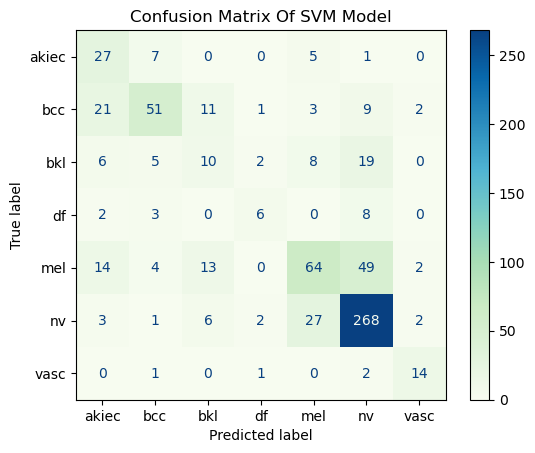

In [41]:
print("\nSVM Classifiẻ Report:")
print(classification_report(test_data['testing_label'], model.predict(test_data['testing_data'])))

cf_matrix = confusion_matrix(test_data['testing_label'], model.predict(test_data['testing_data']))
print("\nConfusion Matrix:")
print(cf_matrix)

# Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
disp.plot(cmap= 'GnBu')
plt.title('Confusion Matrix Of SVM Model')
plt.show()

# Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(test_data['training_data'], test_data['training_labels'])

RandomForestClassifier(random_state=42)


Random Forest Classifier Report:
              precision    recall  f1-score   support

       akiec       0.37      0.68      0.48        40
         bcc       0.71      0.52      0.60        98
         bkl       0.25      0.20      0.22        50
          df       0.50      0.32      0.39        19
         mel       0.60      0.44      0.51       146
          nv       0.75      0.87      0.81       309
        vasc       0.70      0.78      0.74        18

    accuracy                           0.65       680
   macro avg       0.55      0.54      0.53       680
weighted avg       0.65      0.65      0.64       680


Confusion Matrix:
[[ 27   7   0   0   5   1   0]
 [ 21  51  11   1   3   9   2]
 [  6   5  10   2   8  19   0]
 [  2   3   0   6   0   8   0]
 [ 14   4  13   0  64  49   2]
 [  3   1   6   2  27 268   2]
 [  0   1   0   1   0   2  14]]


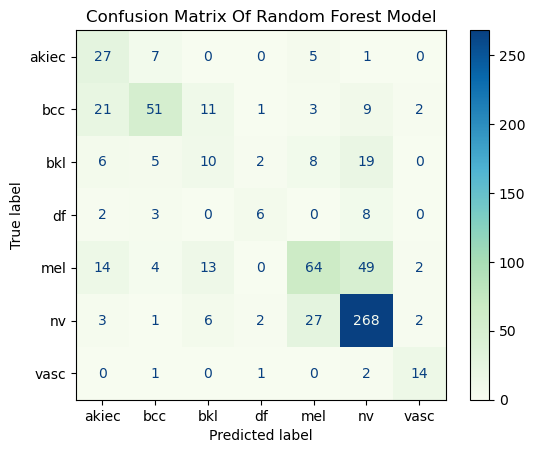

In [42]:
print("\nRandom Forest Classifier Report:")
print(classification_report(test_data['testing_label'], model.predict(test_data['testing_data'])))

cf_matrix = confusion_matrix(test_data['testing_label'], model.predict(test_data['testing_data']))
print("\nConfusion Matrix:")
print(cf_matrix)

# Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
disp.plot(cmap= 'GnBu')
plt.title('Confusion Matrix Of Random Forest Model')
plt.show()

# Light Gradient-Boost Machine 

In [38]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [39]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.1, n_estimators=100)
model.fit(test_data['training_data'], test_data['training_labels'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 27633, number of used features: 512
[LightGBM] [Info] Start training from score -1.934468
[LightGBM] [Info] Start training from score -1.923261
[LightGBM] [Info] Start training from score -1.925244
[LightGBM] [Info] Start training from score -1.983220
[LightGBM] [Info] Start training from score -1.954962
[LightGBM] [Info] Start training from score -1.922519
[LightGBM] [Info] Start training from score -1.979808


LGBMClassifier()


Light-GBM Classifier Report:
              precision    recall  f1-score   support

       akiec       0.37      0.68      0.48        40
         bcc       0.71      0.52      0.60        98
         bkl       0.25      0.20      0.22        50
          df       0.50      0.32      0.39        19
         mel       0.60      0.44      0.51       146
          nv       0.75      0.87      0.81       309
        vasc       0.70      0.78      0.74        18

    accuracy                           0.65       680
   macro avg       0.55      0.54      0.53       680
weighted avg       0.65      0.65      0.64       680


Confusion Matrix:
[[ 27   7   0   0   5   1   0]
 [ 21  51  11   1   3   9   2]
 [  6   5  10   2   8  19   0]
 [  2   3   0   6   0   8   0]
 [ 14   4  13   0  64  49   2]
 [  3   1   6   2  27 268   2]
 [  0   1   0   1   0   2  14]]


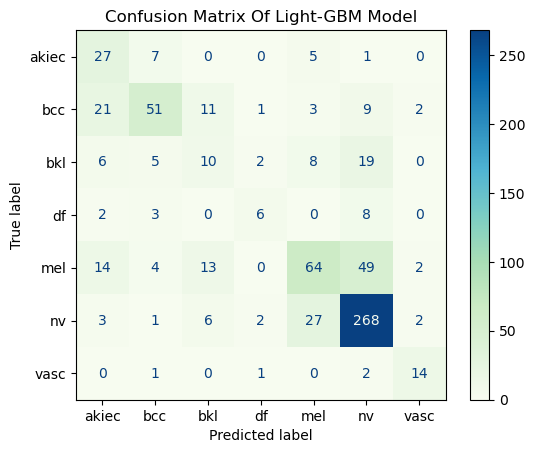

In [43]:
print("\nLight-GBM Classifier Report:")
print(classification_report(test_data['testing_label'], model.predict(test_data['testing_data'])))

cf_matrix = confusion_matrix(test_data['testing_label'], model.predict(test_data['testing_data']))
print("\nConfusion Matrix:")
print(cf_matrix)

# Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
disp.plot(cmap= 'GnBu')
plt.title('Confusion Matrix Of Light-GBM Model')
plt.show()